In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import pycaret.classification as pc

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import mlflow
from mlflow.models.signature import infer_signature
from mlflow.tracking import MlflowClient
from sklearn.model_selection import validation_curve
from sklearn.metrics import log_loss, f1_score
from sklearn.metrics import confusion_matrix

In [2]:
import os
os.environ["MLFLOW_ARTIFACT_ROOT"] = "/home/acer/Pós Machine Learning/Engenharia de Machine Learning/Projeto Engenharia de Machine Learning"

## Configurar MLFLOW

In [3]:
# Para usar o sqlite como repositorio
mlflow.set_tracking_uri("sqlite:///mlruns.db")

experiment_name = 'Treinamento Kobe'
experiment = mlflow.get_experiment_by_name(experiment_name)
if experiment is None:
    experiment_id = mlflow.create_experiment(experiment_name)
    experiment = mlflow.get_experiment(experiment_id)
experiment_id = experiment.experiment_id

2024/04/13 15:46:50 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2024/04/13 15:46:50 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Running upgrade  -> 451aebb31d03, add metric step
INFO  [alembic.runtime.migration] Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
INFO  [alembic.runtime.migration] Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
INFO  [alembic.runtime.migration] Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
INFO  [alembic.runtime.migration] Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
INFO  [alembic.runtime.migration] Running upgrade 7ac759974ad8 -> 89d4b8295536, create latest metrics table
INFO  [89d4b8295536_create_latest_metrics_table_py] Migration complete!
INFO  

In [4]:
data_cols = ['lat', 'lon', 'minutes_remaining', 'period', 'playoffs','shot_distance','shot_made_flag']
train_perc = 0.8

with mlflow.start_run(experiment_id=experiment_id, run_name='PreparacaoDados'):

    df_dev = pd.read_parquet('../data/raw/dataset_kobe_dev.parquet')
    df_dev = df_dev[data_cols].copy()

    # Contar a quantidade de linhas
    total_linhas = len(df_dev)
    print("Total de linhas:", total_linhas)

    # Contar as linhas com dados faltantes
    linhas_faltantes = df_dev.isnull().sum().sum()
    print("Total de linhas com dados faltantes:", linhas_faltantes)

    # Remover linhas com valores faltantes
    df_dev.dropna(inplace=True)

    # Contar a quantidade de linhas após a remoção de dados faltantes
    total_linhas_apos_remocao = len(df_dev)
    print("Total de linhas após remoção de dados faltantes:", total_linhas_apos_remocao)

    df_dev.to_parquet("../data/processed/data_filtered.parquet")

    # Exibir o conjunto de dados resultante após a normalização e remoção de valores faltantes
    print("Conjunto de dados após normalização e remoção de valores faltantes:")
    print(df_dev.head())

    xtrain, xtest, ytrain, ytest = train_test_split(df_dev[['lat', 'lon', 'minutes_remaining', 'period', 'playoffs',
                                                            'shot_distance','shot_made_flag']],
                                                    df_dev['shot_made_flag'],
                                                    train_size=train_perc,
                                                    stratify=df_dev['shot_made_flag'])
    xtrain['shot_made_flag'] = ytrain
    xtest['shot_made_flag'] = ytest
    xtrain.to_parquet('../data/processed/base_train.parquet')
    xtest.to_parquet('../data/processed/base_test.parquet')

    mlflow.log_params({
        'perc-teste': 1 - train_perc,
        'colunas-selecionadas': data_cols
    })
    mlflow.log_metrics({
        'qtd_linhas_treino': xtrain.shape[0],
        'qtd_linhas_teste': xtest.shape[0],
    })

Total de linhas: 24271
Total de linhas com dados faltantes: 3986
Total de linhas após remoção de dados faltantes: 20285
Conjunto de dados após normalização e remoção de valores faltantes:
       lat       lon  minutes_remaining  period  playoffs  shot_distance  \
1  34.0443 -118.4268                 10       1         0             15   
2  33.9093 -118.3708                  7       1         0             16   
3  33.8693 -118.1318                  6       1         0             22   
4  34.0443 -118.2698                  6       2         0              0   
5  34.0553 -118.4148                  9       3         0             14   

   shot_made_flag  
1             0.0  
2             1.0  
3             0.0  
4             1.0  
5             0.0  


## Treinamento do Modelo 

In [5]:
from sklearn.model_selection import validation_curve


def plot_parameter_validation_curve(X, Y, param_name, grid_search,
                                    model, model_name, scoring,
                                    logx):
    print('Parameter:', param_name)
    print('GridSearch:', grid_search[param_name])
    print('Scoring:', scoring)
    plt.figure(figsize=(6,4))
    train_scores, test_scores = validation_curve(model,
                                                 X = X, 
                                                 y = Y, 
                                                 param_name=param_name, 
                                                 param_range= grid_search[param_name],
                                                 scoring=scoring,
                                                 cv=10,
                                                 n_jobs=-1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.title("Curva Validação Modelo " + model_name)
    plt.xlabel(param_name)
    plt.ylabel("Score ("+scoring+")")
    if logx:
        plt.semilogx(grid_search[param_name], train_scores_mean,'-o', label="Treino",
                     color="darkorange", lw=2)
        plt.semilogx(grid_search[param_name], test_scores_mean,'-o', label="Validação-Cruzada",
                     color="navy", lw=2)
    else:
        plt.plot(grid_search[param_name], train_scores_mean,'-o', label="Treino",
                     color="darkorange", lw=2)
        plt.plot(grid_search[param_name], test_scores_mean,'-o', label="Validação-Cruzada",
                 color="navy", lw=2)
    plt.fill_between(grid_search[param_name], train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=2)
    plt.fill_between(grid_search[param_name], test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=2)
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

,Description,Value
0,Session id,1819
1,Target,shot_made_flag
2,Target type,Binary
3,Original data shape,"(20285, 7)"
4,Transformed data shape,"(20285, 7)"
5,Transformed train set shape,"(16228, 7)"
6,Transformed test set shape,"(4057, 7)"
7,Numeric features,6
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,0.5370,0.4921,0.5794,0.5133,0.5444,0.0772,0.0778,0.0500
lr,Logistic Regression,0.5762,0.5000,0.4854,0.5653,0.5223,0.1455,0.1469,0.0300


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.5770,0.5927,0.4961,0.5650,0.5283,0.1478,0.1489


Parameter: C
GridSearch: [0.001, 0.01, 0.1, 1, 10]
Scoring: f1


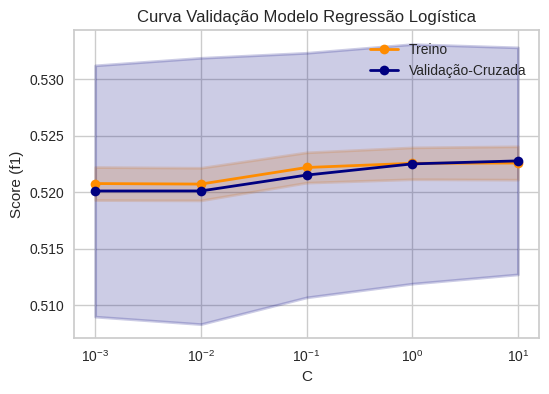

<Figure size 800x550 with 0 Axes>

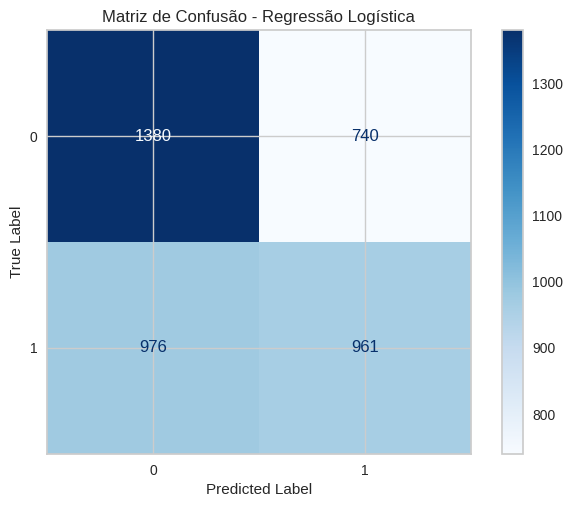

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Decision Tree Classifier,0.5391,0.5191,0.5803,0.5154,0.5459,0.0813,0.0818


Parameter: max_depth
GridSearch: [2, 3, 4, 5, 6, 7, 8]
Scoring: f1


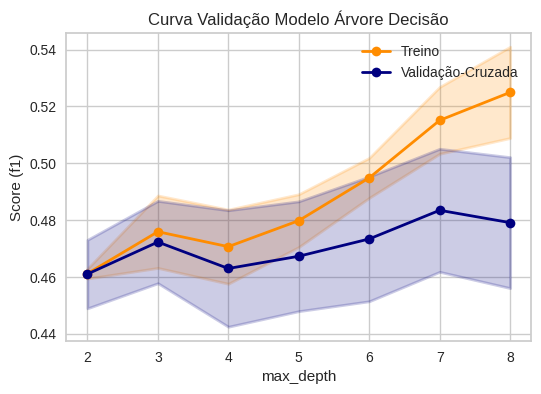

<Figure size 800x550 with 0 Axes>

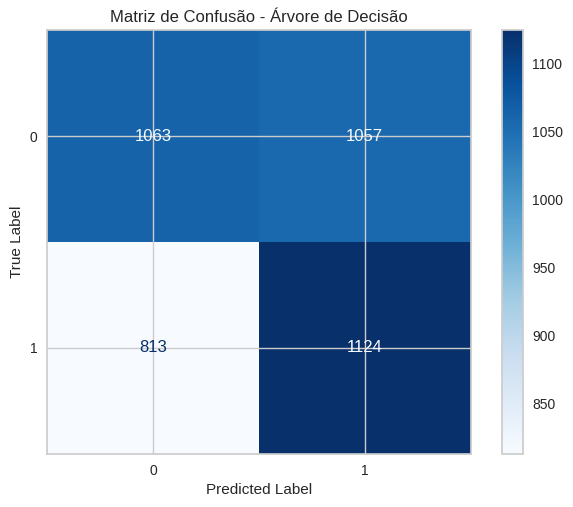

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6051,0.4910,0.3690,0.6530,0.4716,0.1934,0.2136
1,0.5742,0.5153,0.3600,0.5886,0.4468,0.1323,0.1429
2,0.5866,0.5467,0.3703,0.6106,0.4610,0.1572,0.1702
3,0.5915,0.5274,0.3819,0.6167,0.4717,0.1677,0.1805
4,0.5958,0.4960,0.3600,0.6355,0.4596,0.1746,0.1926
5,0.6063,0.4861,0.3690,0.6560,0.4723,0.1958,0.2165
6,0.6001,0.5555,0.4341,0.6143,0.5087,0.1880,0.1961
7,0.5970,0.5755,0.4083,0.6172,0.4914,0.1801,0.1907
8,0.5783,0.4978,0.3463,0.6009,0.4393,0.1389,0.1525


Fitting 10 folds for each of 4 candidates, totalling 40 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Decision Tree Classifier,0.5391,0.5191,0.5803,0.5154,0.5459,0.0813,0.0818


Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Loaded


2024/04/13 16:02:51 WARNING mlflow.utils.requirements_utils: Found lz4 version (3.1.3+dfsg) contains a local version label (+dfsg). MLflow logged a pip requirement for this package as 'lz4==3.1.3' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/04/13 16:02:51 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmplgrzh_um/model/model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.4.1.post1', 'cloudpickle==3.0.0']. Set logging level to DEBUG to see the full traceback. 
Registered model 'model_kobe' already exists. Creating a new version of this model...
Created version '2' of model 'model_kobe'.


In [20]:
import os
from sklearn.metrics import log_loss, f1_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

registered_model_name = 'model_kobe'
nexamples = 5
model_version = -1

with mlflow.start_run(experiment_id=experiment_id, run_name = 'Treinamento'):
  
    exp = pc.setup(
        data=xtrain,
        target = 'shot_made_flag',
        test_data = xtest,
        normalize=True,
        log_experiment = False
    )
    list_models = exp.compare_models(['lr','dt'], n_select=2, sort='f1')

    # REGRESSAO
    # exp.plot_model(list_models[0], plot='vc', save = True)
    yhat_test_lr = exp.predict_model(list_models[1])
    plot_parameter_validation_curve(xtrain.drop('shot_made_flag', axis=1), ytrain, 'C', {'C': [0.001, 0.01, 0.1, 1, 10]},
                                        list_models[1], 'Regressão Logística', 'f1', logx=True)
    plt.savefig('lr_validation_curve.png')
    plt.gcf()
    mlflow.log_artifact('lr_validation_curve.png')
    
    mlflow.log_metrics({
        'lr_log_loss': log_loss(yhat_test_lr['shot_made_flag'], yhat_test_lr['prediction_label']),
        'lr_f1': f1_score(yhat_test_lr['shot_made_flag'], yhat_test_lr['prediction_label']),
    })

    # Plot Matriz de Confusão para Regressão Logística
    cm_lr = confusion_matrix(ytest, yhat_test_lr['prediction_label'])
    disp_lr = ConfusionMatrixDisplay(cm_lr, display_labels=['0', '1'])
    disp_lr.plot(cmap=plt.cm.Blues)
    plt.title("Matriz de Confusão - Regressão Logística")
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.savefig('lr_confusion_matrix.png')
    plt.gcf()
    mlflow.log_artifact('lr_confusion_matrix.png')
    plt.show() 
    
    # ARVORE
    yhat_test_dt = exp.predict_model(list_models[0])
    plot_parameter_validation_curve(xtrain.drop('shot_made_flag', axis=1), ytrain, 'max_depth', {'max_depth': [2, 3, 4, 5, 6, 7, 8]},
                                    list_models[0], 'Árvore Decisão', 'f1', logx=False)
    plt.savefig('dt_validation_curve.png')
    plt.gcf()
    mlflow.log_artifact('dt_validation_curve.png')
    # os.remove('dt_validation_curve.png')

    mlflow.log_metrics({
        'dt_log_loss': log_loss(yhat_test_dt['shot_made_flag'], yhat_test_dt['prediction_label']),
        'dt_f1': f1_score(yhat_test_dt['shot_made_flag'], yhat_test_dt['prediction_label']),
    })

    # Plot Matriz de Confusão para Árvore de Decisão
    cm_dt = confusion_matrix(ytest, yhat_test_dt['prediction_label'])
    disp_dt = ConfusionMatrixDisplay(cm_dt, display_labels=['0', '1'])
    disp_dt.plot(cmap=plt.cm.Blues)
    plt.title("Matriz de Confusão - Árvore de Decisão")
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.savefig('dt_confusion_matrix.png')
    plt.gcf()
    mlflow.log_artifact('dt_confusion_matrix.png')
    plt.show() 
    
     # FINALIZACAO MELHOR MODELO
    tune_model = exp.tune_model(list_models[0],
                                optimize = 'f1',
                                search_library = 'scikit-learn',
                                search_algorithm = 'random',
                                n_iter = 4)
    yhat_test_final = exp.predict_model(tune_model, raw_score=True)  
    mlflow.log_metrics({
        'final_model_log_loss': log_loss(yhat_test_final['shot_made_flag'], yhat_test_final['prediction_label']),
        'final_model_f1': f1_score(yhat_test_final['shot_made_flag'], yhat_test_final['prediction_label']),
    })
    yhat_test_final.to_parquet('../data/processed/prediction_test.parquet')
    mlflow.log_artifact('../data/processed/prediction_test.parquet')
    
    final_model = exp.finalize_model(tune_model)
    
    # EXPORTACAO PARA LOG E REGISTRO DO MODELO
    exp.save_model(final_model, f'./{registered_model_name}') 
    # Carrega novamente o pipeline + bestmodel
    model_pipe = exp.load_model(f'./{registered_model_name}')
    # Assinatura do Modelo Inferida pelo MLFlow
    model_features = list(xtrain.drop('shot_made_flag', axis=1).columns)
    inf_signature = infer_signature(xtrain[model_features], 
                                    model_pipe.predict_proba(xtrain.drop('shot_made_flag', axis=1)))
    # Exemplo de entrada para o MLmodel
    input_example = {x: xtrain[x].values[:nexamples] for x in model_features}
    # Log do pipeline de modelagem do sklearn e registrar como uma nova versao
    mlflow.sklearn.log_model(
        sk_model=model_pipe,
        artifact_path="sklearn-model",
        registered_model_name=registered_model_name,
        signature = inf_signature,
        input_example = input_example,
        pyfunc_predict_fn='predict_proba'
    )
    # Criacao do cliente do servico MLFlow e atualizacao versao modelo
    client = MlflowClient()
    if model_version == -1:
        model_version = client.get_latest_versions(registered_model_name)[-1].version
    # Registrar o modelo como staging
    client.set_registered_model_alias(
        name    = registered_model_name, 
        alias   = "staging", 
        version = model_version
    )
    

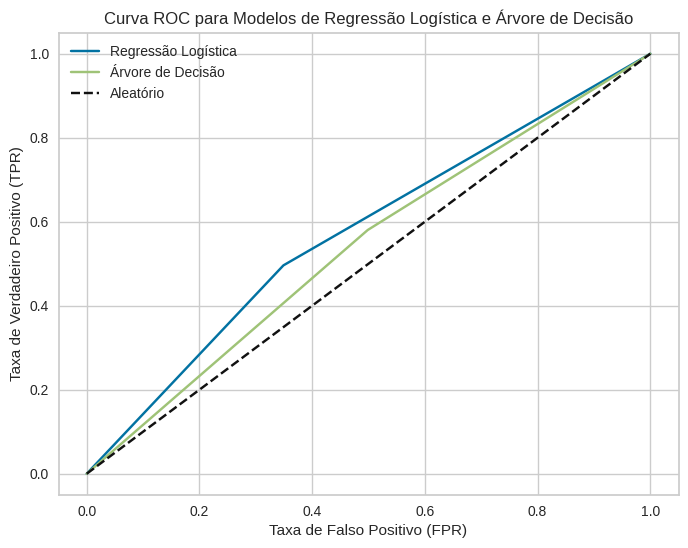

In [23]:
from sklearn.metrics import roc_curve

# Calcula as curvas ROC para ambos os modelos
fpr_lr, tpr_lr, _ = roc_curve(ytest, yhat_test_lr['prediction_label'])
fpr_dt, tpr_dt, _ = roc_curve(ytest, yhat_test_dt['prediction_label'])

# Cria o gráfico
plt.figure(figsize=(8, 6))

# Plota as curvas ROC para ambos os modelos
plt.plot(fpr_lr, tpr_lr, label='Regressão Logística')
plt.plot(fpr_dt, tpr_dt, label='Árvore de Decisão')

# Adiciona linha diagonal para referência
plt.plot([0, 1], [0, 1], 'k--', label='Aleatório')

# Adiciona legendas, título e rótulos aos eixos
plt.title('Curva ROC para Modelos de Regressão Logística e Árvore de Decisão')
plt.xlabel('Taxa de Falso Positivo (FPR)')
plt.ylabel('Taxa de Verdadeiro Positivo (TPR)')
plt.legend()

# Registra o artefato no MLflow
with mlflow.start_run():
    plt.savefig('curva_roc.png')
    mlflow.log_artifact('curva_roc.png')

# Limpa a figura atual para evitar sobreposição
plt.gcf()

# Exibe o gráfico
plt.show()


In [44]:
df1 = pd.read_parquet('../data/processed/prediction_prod.parquet')

df1

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,...,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id,predict_score
10,Jump Shot,Jump Shot,309,20000012,33.8063,-94,238,-118.3638,1,3,...,Left Side Center(LC),Above the Break 3,24+ ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,11,0.0
17,Jump Shot,Jump Shot,138,20000019,33.8183,-117,226,-118.3868,8,2,...,Left Side Center(LC),Above the Break 3,24+ ft.,1610612747,Los Angeles Lakers,2000-11-01,LAL vs. UTA,UTA,18,0.0
27,Jump Shot,Jump Shot,369,20000019,33.8583,-183,186,-118.4528,0,3,...,Left Side Center(LC),Above the Break 3,24+ ft.,1610612747,Los Angeles Lakers,2000-11-01,LAL vs. UTA,UTA,28,0.0
39,Jump Shot,Jump Shot,202,20000047,33.7723,-27,272,-118.2968,0,2,...,Center(C),Above the Break 3,24+ ft.,1610612747,Los Angeles Lakers,2000-11-04,LAL @ VAN,VAN,40,1.0
55,Jump Shot,Jump Shot,80,20000049,33.8503,-155,194,-118.4248,2,1,...,Left Side Center(LC),Above the Break 3,24+ ft.,1610612747,Los Angeles Lakers,2000-11-05,LAL vs. LAC,LAC,56,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30675,Jump Shot,Jump Shot,84,49900088,33.8283,-134,216,-118.4038,2,1,...,Left Side Center(LC),Above the Break 3,24+ ft.,1610612747,Los Angeles Lakers,2000-06-19,LAL vs. IND,IND,30676,0.0
30681,Jump Shot,Jump Shot,218,49900088,33.7833,-18,261,-118.2878,0,2,...,Center(C),Above the Break 3,24+ ft.,1610612747,Los Angeles Lakers,2000-06-19,LAL vs. IND,IND,30682,1.0
30685,Jump Shot,Jump Shot,249,49900088,33.7943,81,250,-118.1888,7,3,...,Center(C),Above the Break 3,24+ ft.,1610612747,Los Angeles Lakers,2000-06-19,LAL vs. IND,IND,30686,0.0
30689,Jump Shot,Jump Shot,326,49900088,33.3653,-12,679,-118.2818,0,3,...,Back Court(BC),Backcourt,Back Court Shot,1610612747,Los Angeles Lakers,2000-06-19,LAL vs. IND,IND,30690,1.0
